In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MultipleLocator
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway, stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error
import math
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization, Normalization
import keras_tuner as kt
from keras_tuner import Objective
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('train.csv', index_col='id')
df

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8


### Eliminar valores atipicos (solo en dataset de entrenamiento)

In [3]:
# Eliminar atipicos
def outliers_iqr(df, column_names, lower_limit=0.01, upper_limit=0.99):
    copy_df = df.copy()
    
    for column_name in column_names:
        # Calcula percentiles para limitar los valores atípicos
        lower_percentile = copy_df[column_name].quantile(lower_limit)
        upper_percentile = copy_df[column_name].quantile(upper_limit)

        # Identifica y elimina las filas que contienen valores atípicos
        copy_df = copy_df[~((copy_df[column_name] < lower_percentile) | (copy_df[column_name] > upper_percentile))]

    return copy_df
    

In [4]:
df = outliers_iqr(df, ['allelectrons_Total','density_Total','ionenergy_Average','el_neg_chi_Average'], 
                            lower_limit=0.01, upper_limit=0.99)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     9695 non-null   float64
 1   density_Total          9695 non-null   float64
 2   allelectrons_Average   9695 non-null   float64
 3   val_e_Average          9695 non-null   float64
 4   atomicweight_Average   9695 non-null   float64
 5   ionenergy_Average      9695 non-null   float64
 6   el_neg_chi_Average     9695 non-null   float64
 7   R_vdw_element_Average  9695 non-null   float64
 8   R_cov_element_Average  9695 non-null   float64
 9   zaratio_Average        9695 non-null   float64
 10  density_Average        9695 non-null   float64
 11  Hardness               9695 non-null   float64
dtypes: float64(12)
memory usage: 984.6 KB


In [11]:
# Guardar csv
df.to_csv('clustering_kmeans_copy.csv', index=False)

In [81]:
# Separamos en X e y
X = df.iloc[:, :-1]
y = df.iloc[:, 11]

In [39]:
y

id
1        6.5
2        2.5
3        6.0
4        6.0
5        6.0
        ... 
10401    6.8
10402    4.0
10404    1.8
10405    6.0
10406    6.5
Name: Hardness, Length: 9695, dtype: float64

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 10406
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     9695 non-null   float64
 1   density_Total          9695 non-null   float64
 2   allelectrons_Average   9695 non-null   float64
 3   val_e_Average          9695 non-null   float64
 4   atomicweight_Average   9695 non-null   float64
 5   ionenergy_Average      9695 non-null   float64
 6   el_neg_chi_Average     9695 non-null   float64
 7   R_vdw_element_Average  9695 non-null   float64
 8   R_cov_element_Average  9695 non-null   float64
 9   zaratio_Average        9695 non-null   float64
 10  density_Average        9695 non-null   float64
dtypes: float64(11)
memory usage: 908.9 KB


### Algoritmo de agrupacion -  nuevas caracteristicas y patrones

In [15]:
# clase personalizada, prediccion de clusters.
class ClusteringClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        # Preservar nombre de columnas
        column_names = X_copy.columns.tolist()
        # Escalado
        scaler = StandardScaler()
        X_copy = scaler.fit_transform(X_copy)
        
        # kmeans
        kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=42)
        y_kmeans = kmeans.fit_predict(X_copy)
        
        # Desescalado de X
        X_copy = scaler.inverse_transform(X_copy)
        
        # transformar a series de pandas(dataframe)
        X_copy = pd.DataFrame(X_copy, columns= column_names)
        
        # Unir nueva columna a X
        X_copy['cluster'] = y_kmeans.tolist()
        
        return X_copy

In [16]:
clustering_class = ClusteringClass()

In [64]:
X = clustering_class.transform(X)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9695 entries, 0 to 9694
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     9695 non-null   float64
 1   density_Total          9695 non-null   float64
 2   allelectrons_Average   9695 non-null   float64
 3   val_e_Average          9695 non-null   float64
 4   atomicweight_Average   9695 non-null   float64
 5   ionenergy_Average      9695 non-null   float64
 6   el_neg_chi_Average     9695 non-null   float64
 7   R_vdw_element_Average  9695 non-null   float64
 8   R_cov_element_Average  9695 non-null   float64
 9   zaratio_Average        9695 non-null   float64
 10  density_Average        9695 non-null   float64
 11  cluster                9695 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 909.0 KB


### Transformaciones matematicas

In [61]:
# clase personalizada, transformaciones de variables.
class MathClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        #Proporcion electrones por densidad
        X_copy['electronic_density'] = X_copy['allelectrons_Total'] / (X_copy['density_Total'].replace(0, np.nan))
        X_copy['electronic_density'] = X_copy['electronic_density'].apply(lambda x: max(0, x))
        
        #Valor medio electrones y energia de ionizacion
        X_copy['v_mean_elecIo'] = X_copy['val_e_Average'] / (X_copy['ionenergy_Average'].replace(0, np.nan))
        X_copy['v_mean_elecIo'] = X_copy['v_mean_elecIo'].apply(lambda x: max(0, x))
        
        
        # haciendo pruebas elimanos las tres ultimas, generan ruido y empeoran los resultados       
        #X_copy = X_copy.drop(['PCA_Component_4', 'electronic_density', 'PCA_Component_2'], axis = 1)
        
        return X_copy

In [62]:
math_class = MathClass()

In [65]:
X = math_class.transform(X)

In [66]:
X.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,cluster,electronic_density,v_mean_elecIo
0,100.0,7.558488,10.000000,4.800000,20.298893,12.04083,2.755000,1.631000,0.910000,0.492719,0.71760,0,13.230159,0.398644
1,76.0,8.885992,15.600000,5.600000,33.739258,12.08630,2.828000,1.788000,0.864000,0.481478,1.50633,0,8.552787,0.463335
2,100.0,8.795296,10.000000,4.800000,20.213349,10.94850,2.648000,1.626000,0.936000,0.489272,0.78937,0,11.369714,0.438416
3,116.0,9.577996,11.600000,4.800000,24.988133,11.82448,2.766000,1.682000,0.896000,0.492736,1.86481,0,12.111093,0.405938
4,131.0,24.529328,21.833333,4.666667,50.131500,11.94820,2.858333,1.758333,0.896667,0.466388,2.94712,0,5.340546,0.390575


In [69]:
# reduccion pca
def reduc_pca(X):
    df_copy = X.copy()
    
    # Selecciona las características afectadas por multicolinealidad
    features_to_pca = df_copy[['atomicweight_Average', 'allelectrons_Average']]
    
    # Estandariza las características antes de aplicar PCA
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_to_pca)
    
    # Aplica PCA
    pca = PCA(n_components=0.95) 
    components = pca.fit_transform(features_scaled)
    print(f"Número de componentes seleccionados: {pca.n_components_}")
    
    # Crea nombres para los nuevos componentes
    new_component_names = [f'PCA_Component_{i+1}' for i in range(components.shape[1])]
    
    # Añade los nuevos componentes al DataFrame
    df_copy[new_component_names] = components
    
    # Elimina las características originales afectadas por multicolinealidad
    df_copy.drop(['atomicweight_Average', 'allelectrons_Average'], axis=1, inplace=True)
    
    # movemos Hardness al final del df
    if 'Hardness' in df_copy.columns:
            if df_copy['Hardness'].isnull().all():
                # La columna 'Hardness' existe y todos sus valores son nulos
                print("Todos los valores de 'Hardness' son nulos.")
            else:
                # La columna 'Hardness' tiene al menos un valor no nulo
                Hardness = df_copy.pop('Hardness')
                df_copy['Hardness'] = Hardness
    else:
        # La columna 'Hardness' no existe en el DataFrame
        print("La columna 'Hardness' no existe en el DataFrame.")
    
    return df_copy

In [70]:
X = reduc_pca(X)

Número de componentes seleccionados: 1
La columna 'Hardness' no existe en el DataFrame.


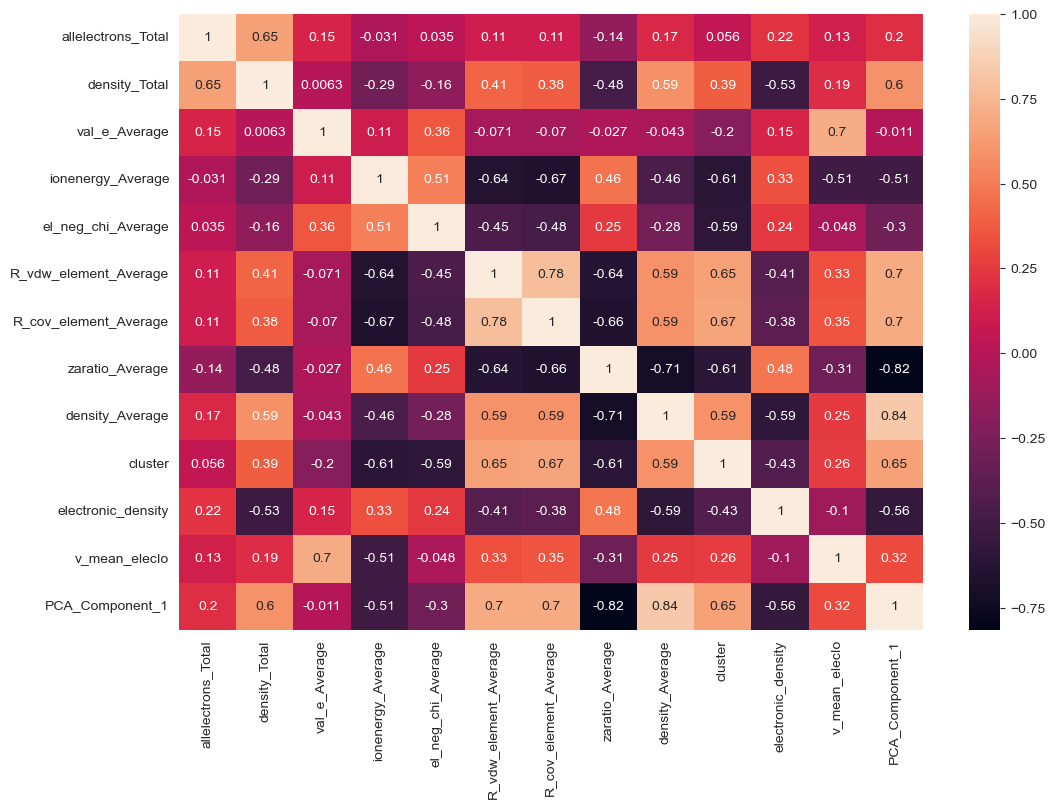

In [71]:
matrix_corr = X.corr(method='spearman')
figure = plt.figure(figsize=(12, 8))
sns.heatmap(matrix_corr, annot=True)
plt.show()

In [72]:
# Importancia segun p-values de las caracteristicas nuevas
f_values, p_values = f_classif(X, y)
anova_results_df = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})
anova_results_df = anova_results_df.sort_values(by='p-value', ascending=True)
print(anova_results_df)

                  Feature    F-value        p-value
8         density_Average  42.076511   0.000000e+00
9                 cluster  58.965467   0.000000e+00
12        PCA_Component_1  56.130313   0.000000e+00
4      el_neg_chi_Average  32.902327  1.417517e-275
6   R_cov_element_Average  23.058958  1.283252e-188
3       ionenergy_Average  17.936900  1.922169e-142
5   R_vdw_element_Average  15.691345  4.496945e-122
1           density_Total   9.748841   2.815661e-68
2           val_e_Average   9.670318   1.424393e-67
11          v_mean_elecIo   9.282423   4.227465e-64
7         zaratio_Average   6.547425   5.231398e-40
0      allelectrons_Total   5.824490   8.019356e-34
10     electronic_density   3.542289   2.242631e-15


### Prediccion con Random Forest, evaluacion y rectificado

In [73]:
# prediccion prueba con random forest
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [75]:
regressor = RandomForestRegressor(random_state=42, oob_score=True)
model = regressor.fit(X_train, y_train)

In [76]:
oob_score = model.oob_score_
print("R^2 Score:", oob_score)

R^2 Score: 0.4509319380328941


In [77]:
# importancia de caracteristicas segun randomforest
for score, name in zip(regressor.feature_importances_, y_train):
    print(round(score, 2), name)

0.05 5.0
0.05 6.0
0.05 3.8
0.13 5.5
0.07 3.5
0.05 6.8
0.07 5.5
0.09 2.5
0.07 5.3
0.02 5.8
0.06 2.5
0.05 5.5
0.24 3.5


In [78]:
y_pred = model.predict(X_test)

In [79]:
#MSE y RMSE
mse = mean_squared_error(y_test, y_pred)
print(mse)
rmse=math.sqrt(mse)
print(rmse)
medae = median_absolute_error(y_test, y_pred)
print('MedAE:', medae)

1.7268730577462605
1.314105421093095
MedAE: 0.7489999999999997


Hemos obtenido una mejora con respecto a la baseline inicial.
Probaremos con otro modelo mas complejo.

*la evaluacion de los modelos en la competicion se realiza con la metrica medae (error absoluto mediano)*

---------------------------------------

Baseline -> MedAE: 0.97

RandomForest -> MedAE: 0.72

### Automatizacion de preprocesado con pipeline

In [107]:
function_transformer = FunctionTransformer(func=reduc_pca)

pipeline = make_pipeline(clustering_class, math_class,function_transformer)

X_processed = pipeline.fit_transform(X)
X_processed

Número de componentes seleccionados: 1
La columna 'Hardness' no existe en el DataFrame.


,allelectrons_Total,density_Total,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,cluster,electronic_density,v_mean_elecIo,PCA_Component_1
0,100.0,7.558488,4.800000,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,0,13.230159,0.398644,-0.955874
1,76.0,8.885992,5.600000,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,0,8.552787,0.463335,-0.173010
2,100.0,8.795296,4.800000,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,0,11.369714,0.438416,-0.958320
3,116.0,9.577996,4.800000,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,0,12.111093,0.405938,-0.707912
4,131.0,24.529328,4.666667,11.948200,2.858333,1.758333,0.896667,0.466388,2.94712,0,5.340546,0.390575,0.739344
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9690,104.0,11.202328,4.666667,11.408267,2.736667,1.796667,0.966667,0.485033,1.95480,0,9.283785,0.409060,0.129033
9691,128.0,7.558488,4.000000,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,0,16.934604,0.353031,-0.639492
9692,196.0,30.920000,5.500000,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1,6.338939,0.545944,1.025147
9693,38.0,1.553160,4.666667,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,0,24.466249,0.413344,-0.585295


### Caracteristicas predictoras-añadir nuevas en base a predicciones

In [108]:
# prediccion xgboost.

# prediccion con xgboost antes de utilizar redes neuronales, para añadir caracteristica nueva 
# Divide tus datos en conjuntos de entrenamiento y val
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
xgb_rr = XGBRegressor(objective ='reg:squarederror', 
                      n_estimators = 10, seed = 123)

xgb_rr.fit(X_train, y_train) 
xgb_rr_pred = xgb_rr.predict(X_test)
xgb_rr_mae = median_absolute_error(y_test, xgb_rr_pred)

print(f'Median Absolute Error for XGBRegressor  with reg:squarederror is:{xgb_rr_mae: .6f}')
    
# Añadir caracteristicas a X_processed
X_processed['Hardness_xgb'] = xgb_rr.predict(X_processed)

Median Absolute Error for XGBRegressor  with reg:squarederror is: 0.701327


In [109]:
# prediccion linear regresion.
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

linear_rr = LinearRegression(n_jobs=-1).fit(X_train, y_train)
linear_score = linear_rr.predict(X_test)
linear_mae = median_absolute_error(y_test, linear_score)
print(f'Median Absolute Error for linear regression  with reg:squarederror is:{linear_mae: .6f}')

# Añadir caracteristicas a X_processed
X_processed['Hardness_lin'] = linear_rr.predict(X_processed)

Median Absolute Error for linear regression  with reg:squarederror is: 0.660969


In [110]:
# Importancia segun p-values de las caracteristicas nuevas
f_values, p_values = f_classif(X_processed, y)
anova_results_df = pd.DataFrame({'Feature': X_processed.columns, 'F-value': f_values, 'p-value': p_values})
anova_results_df = anova_results_df.sort_values(by='p-value', ascending=True)
print(anova_results_df)

                  Feature     F-value        p-value
8         density_Average   42.076511   0.000000e+00
9                 cluster   58.965467   0.000000e+00
12        PCA_Component_1   56.130313   0.000000e+00
13           Hardness_xgb  271.187619   0.000000e+00
14           Hardness_lin  274.102749   0.000000e+00
4      el_neg_chi_Average   32.902327  1.417517e-275
6   R_cov_element_Average   23.058958  1.283252e-188
3       ionenergy_Average   17.936900  1.922169e-142
5   R_vdw_element_Average   15.691345  4.496945e-122
1           density_Total    9.748841   2.815661e-68
2           val_e_Average    9.670318   1.424393e-67
11          v_mean_elecIo    9.282423   4.227465e-64
7         zaratio_Average    6.547425   5.231398e-40
0      allelectrons_Total    5.824490   8.019356e-34
10     electronic_density    3.542289   2.242631e-15


In [111]:
def delete_features(X):
    X_processed_copy = X.copy()
    # prueba eliminando p-values mas alto.
    X_processed_copy = X_processed_copy.drop(['electronic_density'], axis = 1)
    return X_processed_copy
    

In [112]:
X_processed = delete_features(X_processed)

Realizando diferentes pruebas y predicciones, vi que la mejor opcion es mantener las caracteristicas descritas arriba.
En la nueva funcion delete_features

Podemos ver la prueba con XGBoost en la celda de abajo.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    
xgb_rr2 = XGBRegressor(objective ='reg:squarederror', 
                      n_estimators = 10, seed = 123)

xgb_rr2.fit(X_train, y_train) 
xgb_rr_pred2 = xgb_rr2.predict(X_test)
xgb_rr_mae2 = median_absolute_error(y_test, xgb_rr_pred2)

print(f'Median Absolute Error for XGBRegressor  with reg:squarederror is:{xgb_rr_mae2: .6f}')

Median Absolute Error for XGBRegressor  with reg:squarederror is: 0.664272


### Prediccion con Redes Neuronales

### Keras Tuner, busqueda aleatoria de hiperparametros

In [116]:
# prediccion prueba con redes neuronales
# Divide tus datos en conjuntos de entrenamiento y prueba sobrescribiendo el anterior
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [118]:
def model (hp):
    # hiperparametros con x valores posibles
    n_hidden = hp.Int('n_hidden', min_value=0, max_value=100, default=2)
    n_neurons = hp.Int('n_neurons', min_value=1, max_value=120)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', values=['adam'])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Contruccion de red con api secuancial
    model = tf.keras.Sequential()
    model.add(Normalization())
    model.add(tf.keras.layers.Flatten())
    # creando n capas
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
        model.add(BatchNormalization())
    # capa de salida    
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError'])
    
    return model

In [119]:
random_search_tuner = kt.RandomSearch(
    model, Objective("val_root_mean_squared_error", direction="min"), max_trials=10, overwrite=True, seed=42
)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
random_search_tuner.search(X_train, y_train, epochs=100, callbacks=[early_stop], validation_data=(X_test, y_test))

Trial 10 Complete [00h 02m 04s]
val_root_mean_squared_error: 4.768338680267334

Best val_root_mean_squared_error So Far: 1.2988280057907104
Total elapsed time: 00h 23m 03s


In [121]:
# cargamos el mejor modelo hasta la fecha
top3_models = random_search_tuner.get_best_models(num_models=3)
best_models = top3_models[0]

### Ajuste manual de hiperparametros

In [168]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_dim=14)

modelo = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(9, activation='relu'),
     BatchNormalization(),
    tf.keras.layers.Dense(9, activation='relu'),
     BatchNormalization(),
    tf.keras.layers.Dense(9, activation='relu'),
     BatchNormalization(),
    tf.keras.layers.Dense(9, activation='relu'),
     BatchNormalization(),
    tf.keras.layers.Dense(9, activation='relu'),
     BatchNormalization(),
    tf.keras.layers.Dense(9, activation='relu'),
     BatchNormalization(),
    tf.keras.layers.Dense(9, activation='relu'),
     BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear'),
])

optimizador = tf.keras.optimizers.Adam(learning_rate=0.000085)
modelo.compile(optimizer=optimizador, loss='mse', metrics=['RootMeanSquaredError'])
norm_layer.adapt(X_train)


In [139]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [169]:
# Ajustar y entrenar el modelo de red neuronal
history=modelo.fit(X_train, y_train, epochs=220,validation_data=(X_test, y_test))

Epoch 1/220
243/243 [==============================] - 5s 5ms/step - loss: 25.2539 - root_mean_squared_error: 5.0253 - val_loss: 22.0386 - val_root_mean_squared_error: 4.6945
Epoch 2/220
243/243 [==============================] - 1s 4ms/step - loss: 24.0143 - root_mean_squared_error: 4.9004 - val_loss: 22.7805 - val_root_mean_squared_error: 4.7729
Epoch 3/220
243/243 [==============================] - 1s 4ms/step - loss: 23.0857 - root_mean_squared_error: 4.8048 - val_loss: 22.2469 - val_root_mean_squared_error: 4.7167
Epoch 4/220
243/243 [==============================] - 1s 4ms/step - loss: 22.2209 - root_mean_squared_error: 4.7139 - val_loss: 21.6258 - val_root_mean_squared_error: 4.6504
Epoch 5/220
243/243 [==============================] - 1s 4ms/step - loss: 21.3709 - root_mean_squared_error: 4.6229 - val_loss: 20.8518 - val_root_mean_squared_error: 4.5664
Epoch 6/220
243/243 [==============================] - 1s 4ms/step - loss: 20.4018 - root_mean_squared_error: 4.5168 - val_lo

Epoch 48/220
243/243 [==============================] - 1s 4ms/step - loss: 1.4819 - root_mean_squared_error: 1.2173 - val_loss: 1.8412 - val_root_mean_squared_error: 1.3569
Epoch 49/220
243/243 [==============================] - 1s 4ms/step - loss: 1.4438 - root_mean_squared_error: 1.2016 - val_loss: 1.8371 - val_root_mean_squared_error: 1.3554
Epoch 50/220
243/243 [==============================] - 1s 4ms/step - loss: 1.4534 - root_mean_squared_error: 1.2056 - val_loss: 1.8351 - val_root_mean_squared_error: 1.3547
Epoch 51/220
243/243 [==============================] - 1s 4ms/step - loss: 1.4325 - root_mean_squared_error: 1.1969 - val_loss: 1.8266 - val_root_mean_squared_error: 1.3515
Epoch 52/220
243/243 [==============================] - 1s 4ms/step - loss: 1.4452 - root_mean_squared_error: 1.2022 - val_loss: 1.8218 - val_root_mean_squared_error: 1.3497
Epoch 53/220
243/243 [==============================] - 1s 4ms/step - loss: 1.4653 - root_mean_squared_error: 1.2105 - val_loss: 1

243/243 [==============================] - 1s 4ms/step - loss: 1.3010 - root_mean_squared_error: 1.1406 - val_loss: 1.7202 - val_root_mean_squared_error: 1.3116
Epoch 96/220
243/243 [==============================] - 1s 4ms/step - loss: 1.3094 - root_mean_squared_error: 1.1443 - val_loss: 1.7155 - val_root_mean_squared_error: 1.3098
Epoch 97/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2979 - root_mean_squared_error: 1.1392 - val_loss: 1.7157 - val_root_mean_squared_error: 1.3098
Epoch 98/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2868 - root_mean_squared_error: 1.1344 - val_loss: 1.7176 - val_root_mean_squared_error: 1.3106
Epoch 99/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2801 - root_mean_squared_error: 1.1314 - val_loss: 1.7195 - val_root_mean_squared_error: 1.3113
Epoch 100/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2795 - root_mean_squared_error: 1.1311 - val_loss: 1.7178 - val_

Epoch 142/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2463 - root_mean_squared_error: 1.1164 - val_loss: 1.6997 - val_root_mean_squared_error: 1.3037
Epoch 143/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2418 - root_mean_squared_error: 1.1144 - val_loss: 1.6998 - val_root_mean_squared_error: 1.3038
Epoch 144/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2308 - root_mean_squared_error: 1.1094 - val_loss: 1.6976 - val_root_mean_squared_error: 1.3029
Epoch 145/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2423 - root_mean_squared_error: 1.1146 - val_loss: 1.6989 - val_root_mean_squared_error: 1.3034
Epoch 146/220
243/243 [==============================] - 1s 5ms/step - loss: 1.2231 - root_mean_squared_error: 1.1059 - val_loss: 1.6978 - val_root_mean_squared_error: 1.3030
Epoch 147/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2327 - root_mean_squared_error: 1.1102 - val_l

Epoch 189/220
243/243 [==============================] - 1s 5ms/step - loss: 1.2113 - root_mean_squared_error: 1.1006 - val_loss: 1.7037 - val_root_mean_squared_error: 1.3053
Epoch 190/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2121 - root_mean_squared_error: 1.1009 - val_loss: 1.6924 - val_root_mean_squared_error: 1.3009
Epoch 191/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2108 - root_mean_squared_error: 1.1003 - val_loss: 1.6943 - val_root_mean_squared_error: 1.3016
Epoch 192/220
243/243 [==============================] - 1s 4ms/step - loss: 1.2006 - root_mean_squared_error: 1.0957 - val_loss: 1.7004 - val_root_mean_squared_error: 1.3040
Epoch 193/220
243/243 [==============================] - 1s 5ms/step - loss: 1.1965 - root_mean_squared_error: 1.0938 - val_loss: 1.6920 - val_root_mean_squared_error: 1.3008
Epoch 194/220
243/243 [==============================] - 1s 6ms/step - loss: 1.2070 - root_mean_squared_error: 1.0986 - val_l

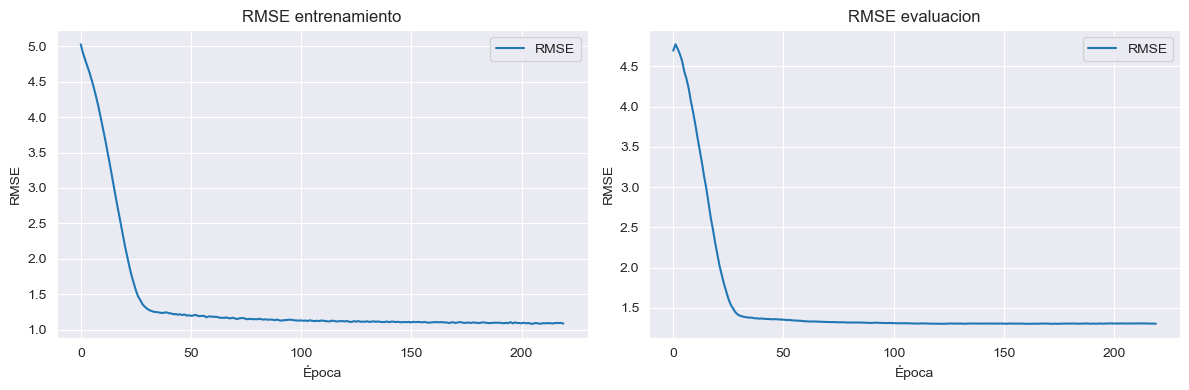

In [170]:
# Obtener las métricas de entrenamiento
loss = history.history['root_mean_squared_error']
mse = history.history['val_root_mean_squared_error']

# Graficar la pérdida y la métrica MSE
plt.figure(figsize=(12, 4))

# Gráfico de RMSE entrenamiento
plt.subplot(1, 2, 1)
plt.plot(loss, label='RMSE')
plt.title('RMSE entrenamiento')
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.legend()

# Gráfico de RMSE evaluacion
plt.subplot(1, 2, 2)
plt.plot(mse, label='RMSE')
plt.title('RMSE evaluacion')
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [171]:
y_pred = modelo.predict(X_test)

61/61 [==============================] - 0s 2ms/step


In [172]:
medae = median_absolute_error(y_test, y_pred)
print('medae=',medae)

medae= 0.6704902648925781


Nos quedaremos con el modelo encontrado por keras-tuner, siendo mejor al modelo por busqueda manual

### Prediccion con el conjunto de prueba

In [173]:
df_prueba = pd.read_csv('test.csv')
df_prueba

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...,...
6934,17341,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
6935,17342,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
6936,17343,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425
6937,17344,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227


In [174]:
id_ = df_prueba['id']
df_prueba = df_prueba.drop('id', axis = 1)

In [175]:
# llamamos a las funciones y pipeline de preprocesamiento
X_prueba = pipeline.fit_transform(df_prueba)
X_prueba['Hardness_xgb'] = xgb_rr.predict(X_prueba)
X_prueba['Hardness_lin'] = linear_rr.predict(X_prueba)
X_prueba = delete_features(X_prueba)

Número de componentes seleccionados: 1
La columna 'Hardness' no existe en el DataFrame.


In [176]:
X_prueba

,allelectrons_Total,density_Total,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,cluster,v_mean_elecIo,PCA_Component_1,Hardness_xgb,Hardness_lin
0,884.0,121.420000,5.280000,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459,0,0.563477,2.296082,3.784352,3.524940
1,90.0,9.931960,5.600000,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194,1,0.463335,0.067806,2.986371,2.752558
2,116.0,7.767992,4.800000,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834,1,0.435420,-0.766252,5.589342,6.031378
3,100.0,9.107996,4.800000,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466,1,0.397144,-0.944997,4.260962,4.387753
4,55.0,4.030000,4.000000,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456,1,0.354580,-0.811411,4.562771,4.714816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6934,446.0,36.135392,4.636364,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548,1,0.419751,-0.984143,5.914231,6.409444
6935,36.0,3.550000,4.000000,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045,0,0.485637,-0.022697,3.682788,3.120642
6936,68.0,4.545328,5.333333,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425,1,0.487581,-0.797443,5.610052,6.028192
6937,40.0,2.334164,4.000000,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227,1,0.314949,-1.347704,4.283691,4.740445


In [177]:
prediction = best_models.predict(X_prueba)

217/217 [==============================] - 1s 2ms/step


In [178]:
# Convertir cada matriz a un array NumPy unidimensional
prediction = np.squeeze(prediction)

In [182]:
df_submission = {'id': id_, 'Hardness': np.round(prediction, 3)}

In [183]:
data = pd.DataFrame(df_submission)
data

,id,Hardness
0,10407,1.414
1,10408,3.114
2,10409,6.021
3,10410,4.640
4,10411,4.790
...,...,...
6934,17341,5.525
6935,17342,3.345
6936,17343,6.021
6937,17344,4.712


In [184]:
#guardar archivo csv
data.to_csv("Mosh_HardnessV5.csv", index=False)